In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

from collections import defaultdict, Counter
from tqdm import tqdm

from f723.tools.urs.extraction import assemble_chains, iterate_urs_models

%matplotlib inline

In [3]:
NRLIST_PATH = '/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv'
CIF_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/cif/'
OUT_DIR = '/home/mikhail/bioinformatics/data/NR_3.0/out/'
NRLIST_PATH = '/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv'
SEC_STRUCT_DIR = '/home/mikhail/bioinformatics/data/sec_struct'

In [4]:
all_chains = assemble_chains(NRLIST_PATH, CIF_DIR, OUT_DIR, SEC_STRUCT_DIR)

100%|██████████| 1074/1074 [00:57<00:00, 18.75it/s]


In [5]:
chains = []

for chain in all_chains:
    noncanonical_dists = [abs(bp.nt_left.index - bp.nt_right.index) for bp in chain.noncanonical_bps]
    mean_dist = np.mean(noncanonical_dists)
    median_dist = np.median(noncanonical_dists)

    chains.append({
        'id': (chain.pdb_id, chain.id),
        'nts': len(chain.nts),
        'noncanonical': len(chain.noncanonical_bps),
        'ss': len(chain.ss_bps),
        'mean_dist': mean_dist,
        'median_dist': median_dist,
        'noncanonical_dists': noncanonical_dists
    })

/home/mikhail/venv/f723/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikhail/venv/f723/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
len(chains)

1504

In [7]:
def draw_stats(chains):
    graph_keys = [
        ('nts', 'ss'), 
        ('nts', 'noncanonical'), 
        ('ss', 'noncanonical'), 
        ('nts', 'mean_dist'), 
        ('nts', 'median_dist')
    ]

    for x_key, y_key in graph_keys:
        plt.figure(figsize=(20, 10))

        plt.xlabel(x_key, fontsize=23)
        plt.ylabel(y_key, fontsize=23)

        plt.scatter([c[x_key] for c in chains], [c[y_key] for c in chains])

Посмотрим на распределение пар в цепочках.  
ss -- количество пар вторичной структуры в цепочке  
nts -- количество нуклеотидов в цепочке  
noncanonical -- количество пар не лежащих во вторичной структуре в цепочке  
mean_dist, median_dist -- среднее и медиана расстояний между нуклеотидами в паре по цепочке. Расстояния берутся в смысле порядковых номеров нуклеотидов.

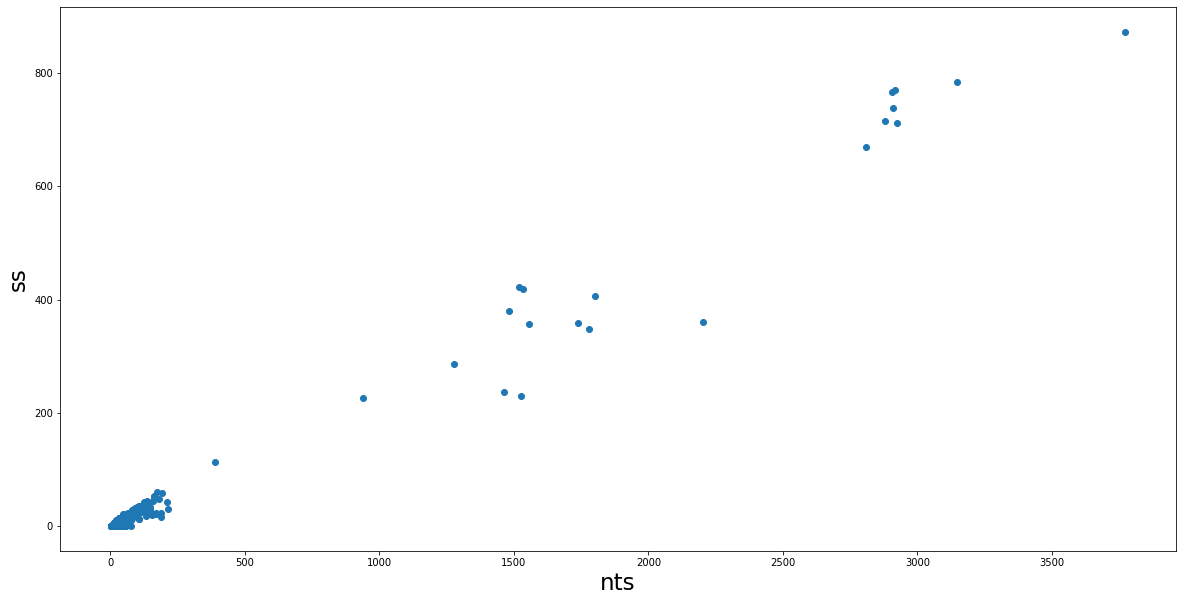

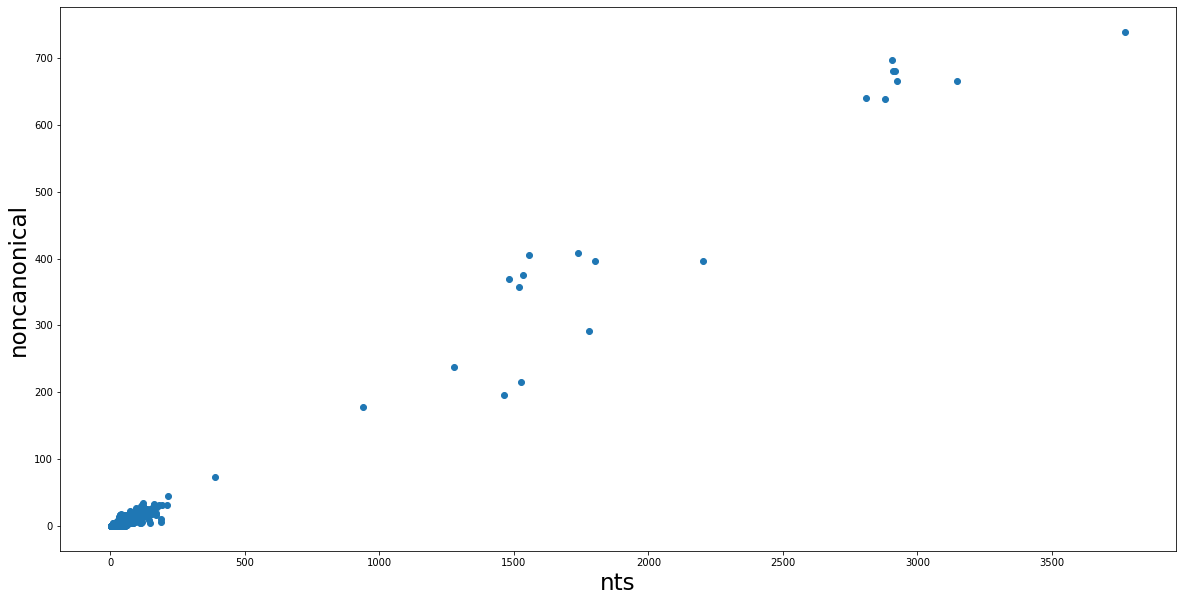

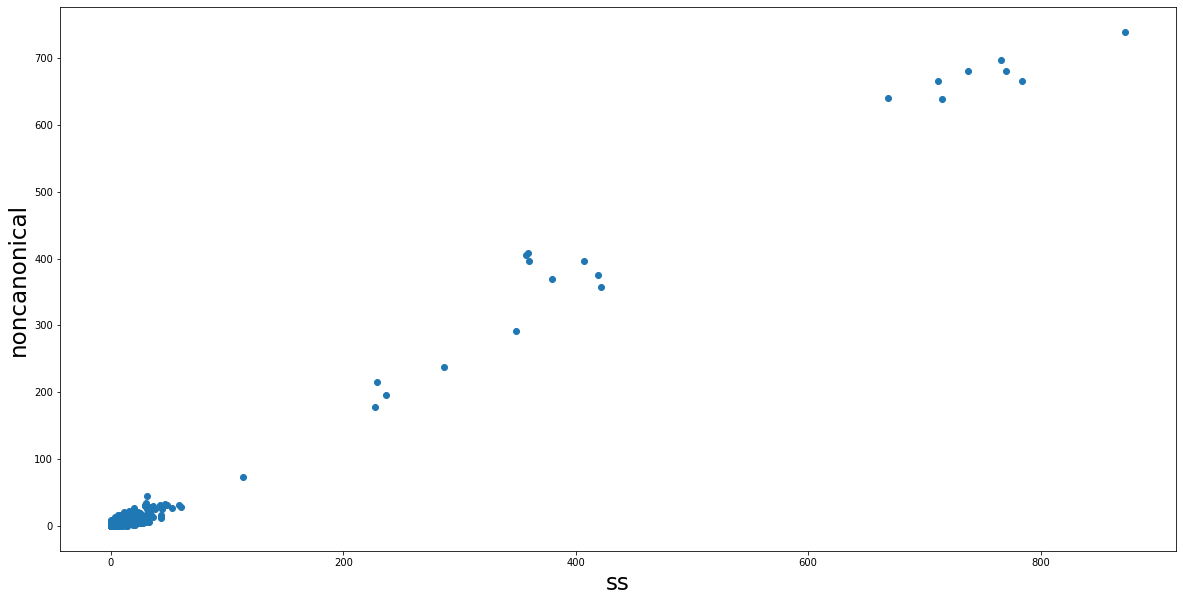

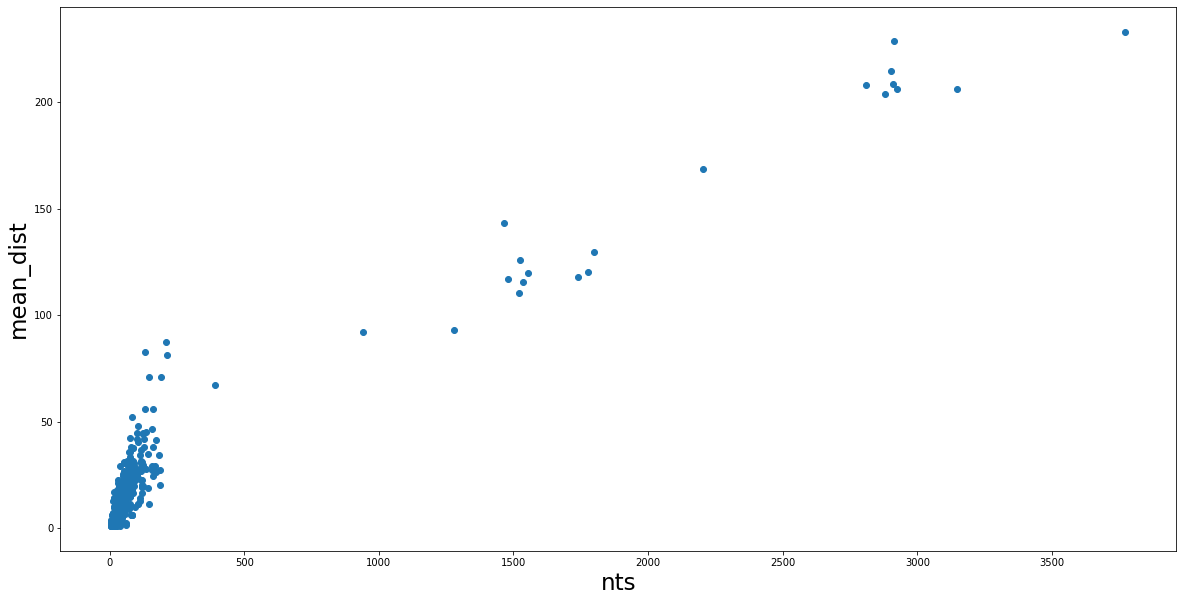

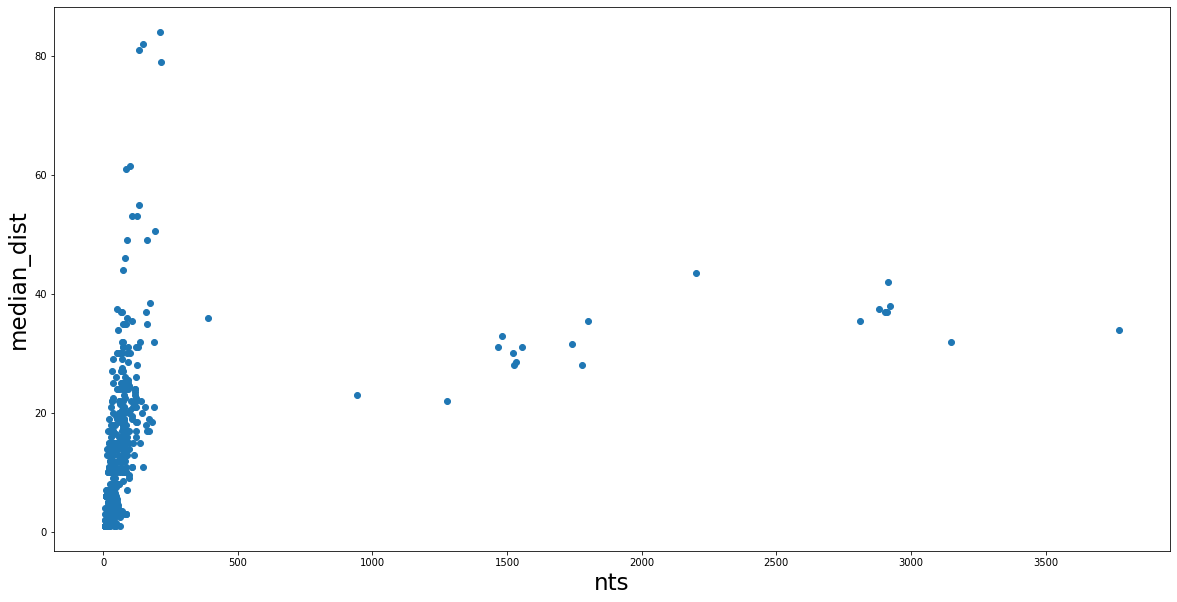

In [8]:
draw_stats(chains)

Длина большинства цепочек не превышает 300 нуклеотидов. Также есть совсем мало цепочек, длина которых существенно больше остальных. На это стоит обратить особое внимание, так как из опыта в других областях, часто структуры разных размеров обнаруживают разные свойства.

Отметим линейный рост количества неканонических пар в зависимости от количества нуклеотидов. Это позволяет выдвинуть гипотезу, о том что характер неканонических спариваний локален, и на самом деле длина цепочки не так важна. В пользу этой гипотезы также говорит тот факт, что медиана расстояния нуклеотидов в спаривании по цепочке не растет. Среднее растет, но это мало что значит, потому что среднее может сильно шуметь из-за выбросов.

In [9]:
exists_noncanonical = {c['id'] for c in chains if c['noncanonical'] > 0}
exists_secondary = {c['id'] for c in chains if c['ss'] > 0}

len(exists_noncanonical), len(exists_secondary), len(exists_secondary & exists_noncanonical)

(449, 442, 398)

Нас интересуют цепочки, имеющие вторичную структуру и неканонические спаривания, как видим, их довольно мало.

In [10]:
chains_for_classification = [c for c in chains if c['id'] in exists_secondary & exists_noncanonical]

len(chains_for_classification)

398

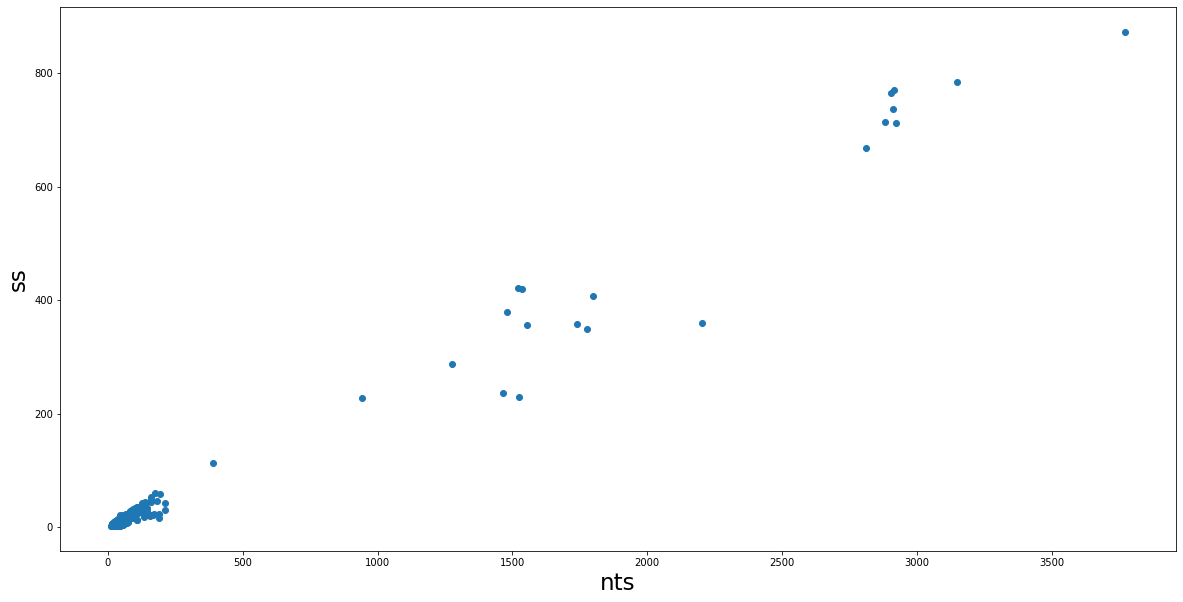

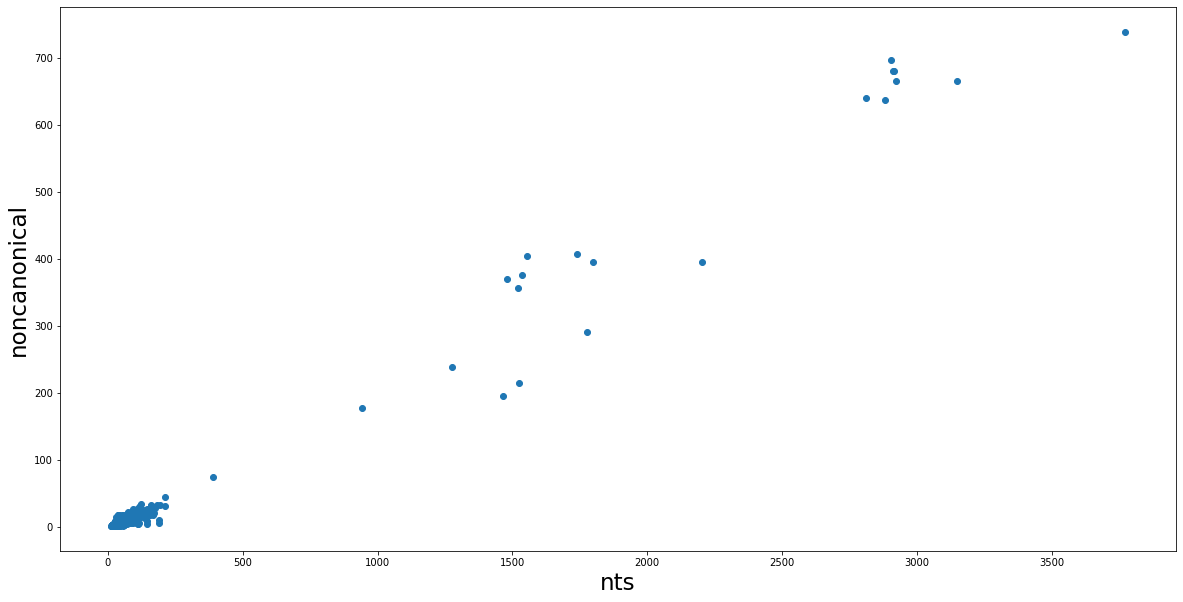

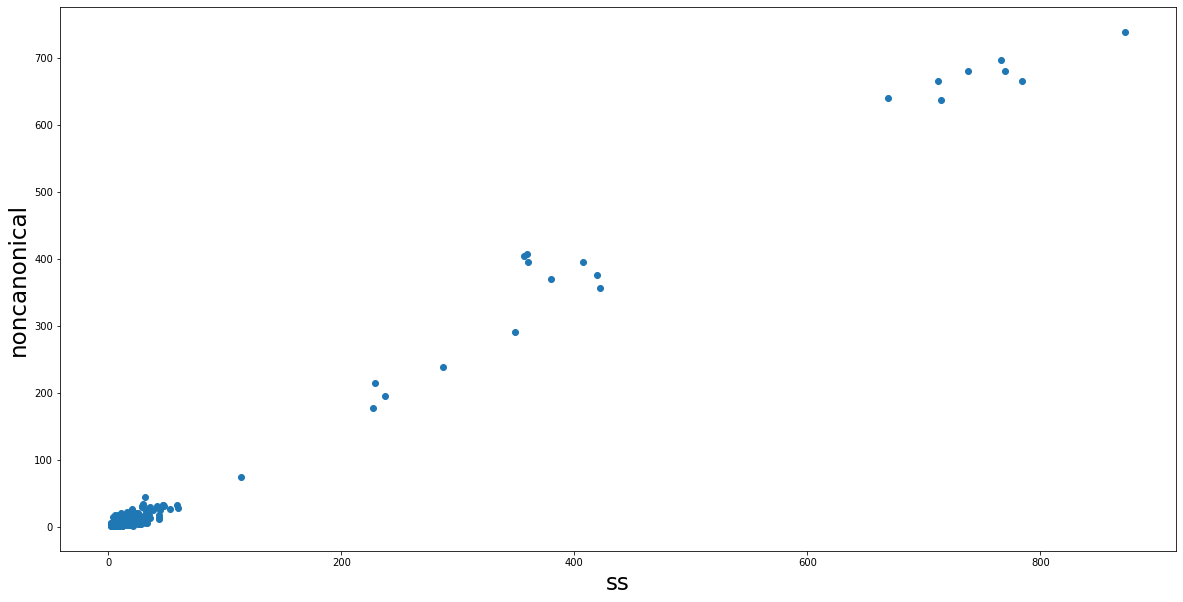

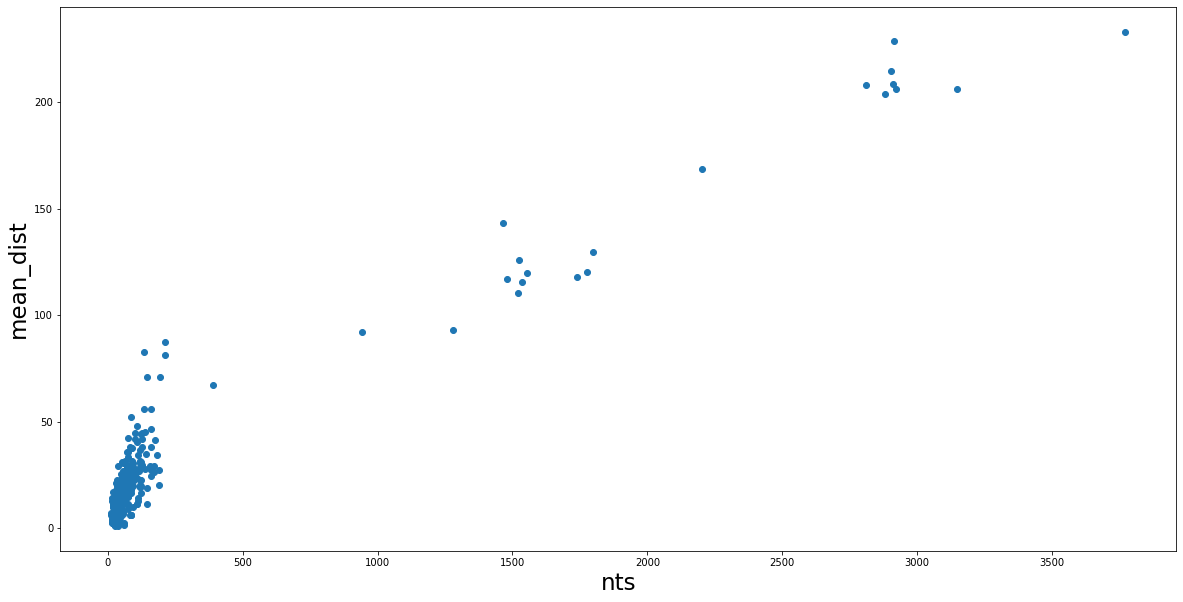

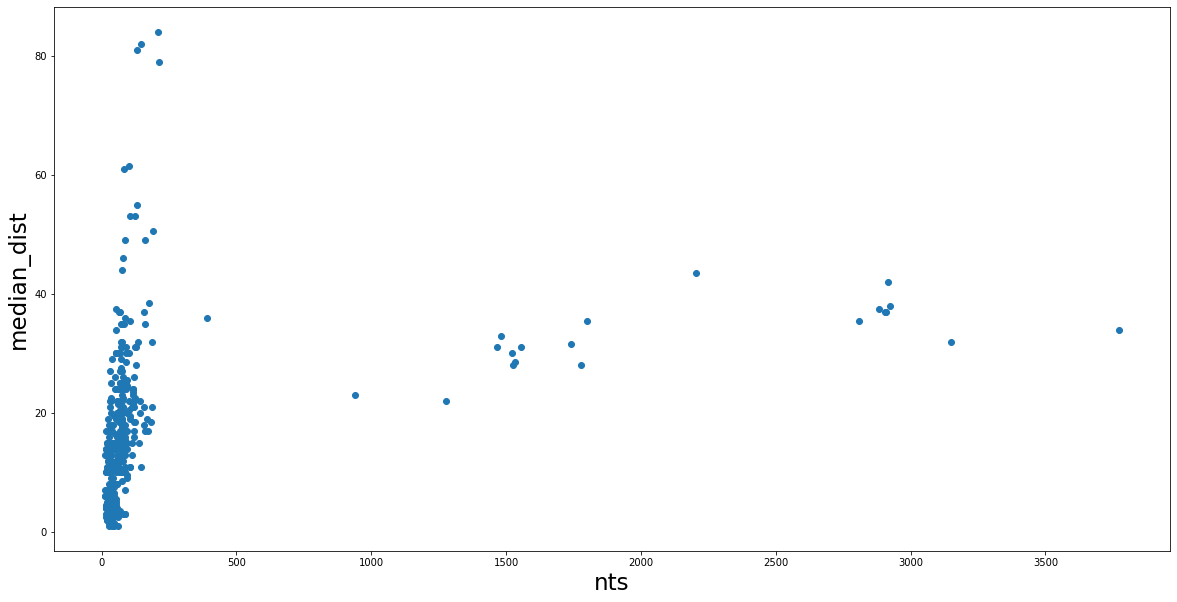

In [11]:
draw_stats(chains_for_classification)

Нарисовали все те же графики для цепочек, подходящих для классификации, на графиках та же картина.

In [12]:
def draw_classification_stats(chains_for_classification):
    all_noncanonical = [c['noncanonical'] for c in chains_for_classification]
    all_nts = [c['nts'] for c in chains_for_classification]
    all_pairs = [c['nts'] * (c['nts'] - 1) // 2 for c in chains_for_classification]
    positive_rate = [noncanonical / pairs for noncanonical, pairs in zip(all_noncanonical, all_pairs)]
    
    stats = {
        'noncanonical': all_noncanonical,
        'nts': all_nts,
        'pairs': all_pairs,
        'positive_rate': positive_rate
    }

    stats_message = 'noncanonical sum: {}; nts sum: {}; pairs sum: {}; mean_positive_rate: {}'.format(
        sum(stats['noncanonical']), sum(stats['nts']), sum(stats['pairs']), np.mean(stats['positive_rate']))
    print(stats_message)
    
    print('Noncanonical dists distribution')
    
    all_noncanonical_dists = sum([c['noncanonical_dists'] for c in chains_for_classification], [])
    plt.figure(figsize=(20, 10))
    plt.hist(all_noncanonical_dists, bins=1000);
    plt.show()
    
    graph_keys = [
        ('pairs', 'noncanonical'),
        ('nts', 'positive_rate')
    ]

    for x_key, y_key in graph_keys:
        plt.figure(figsize=(20, 10))

        plt.xlabel(x_key, fontsize=23)
        plt.ylabel(y_key, fontsize=23)

        plt.scatter(stats[x_key], stats[y_key])

Теперь будет работать только с цепочками, пригодными для классификации. Посмотрим на:  
1) Общее количество неканонических пар в цепочках -- noncanonical sum  
2) Общее количество пар в цепочках: pairs sum  
3) Среднее отношения количества неканонических пар в цепочке к общему количеству пар в цепочке -- mean_positive_rate  
4) Возьмем все неканонические пары и построим гистограмму для расстояния в паре (в смысле порядковых номеров нуклеотидов)  
5) Зависимость количества неканонических пар от общего количества пар  
6) Зависимость positive_rate от количества нуклеотидов в цепочке  

noncanonical sum: 12926; nts sum: 67778; pairs sum: 53519907; mean_positive_rate: 0.005700252702168318
Noncanonical dists distribution


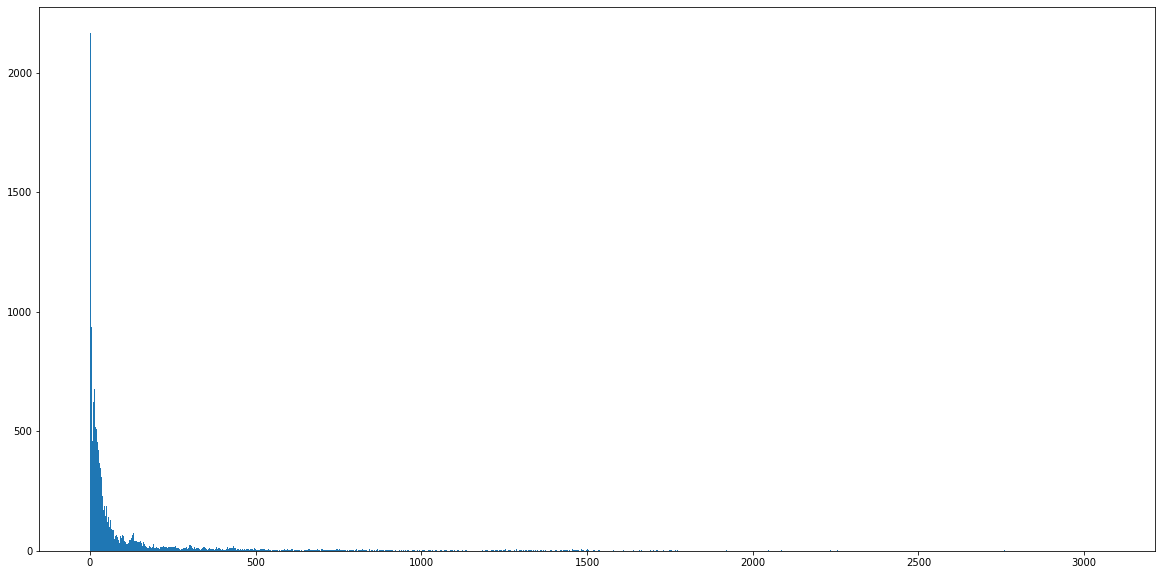

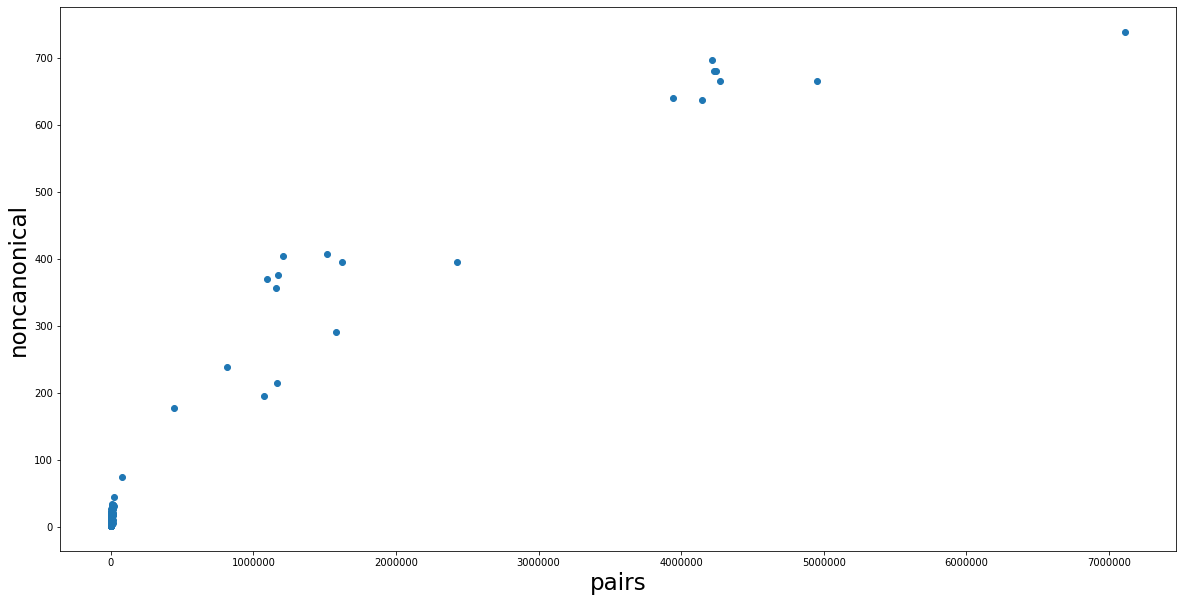

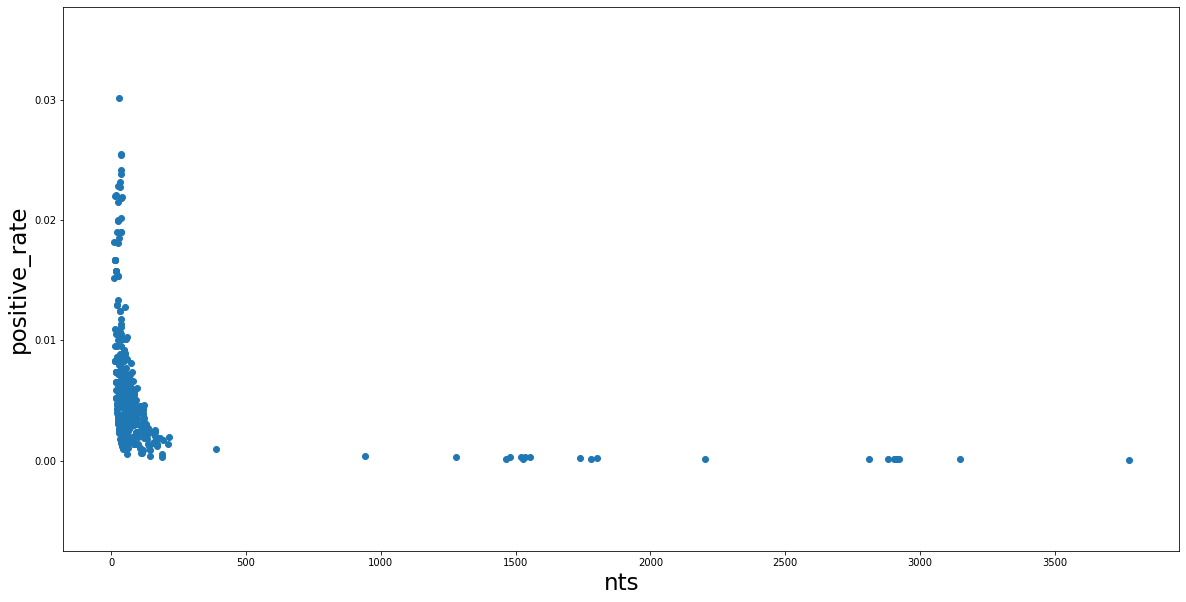

In [13]:
draw_classification_stats(chains_for_classification)

Имеем всего около 5000 положительных примеров. Это довольно мало.

Рассмотрим отдельно короткие цепочки, которых большинство

In [14]:
short_chains = [c for c in chains_for_classification if c['nts'] < 300]
len(short_chains), len(chains_for_classification) - len(short_chains)

(377, 21)

noncanonical sum: 3620; nts sum: 24301; pairs sum: 1043494; mean_positive_rate: 0.006003458679596197
Noncanonical dists distribution


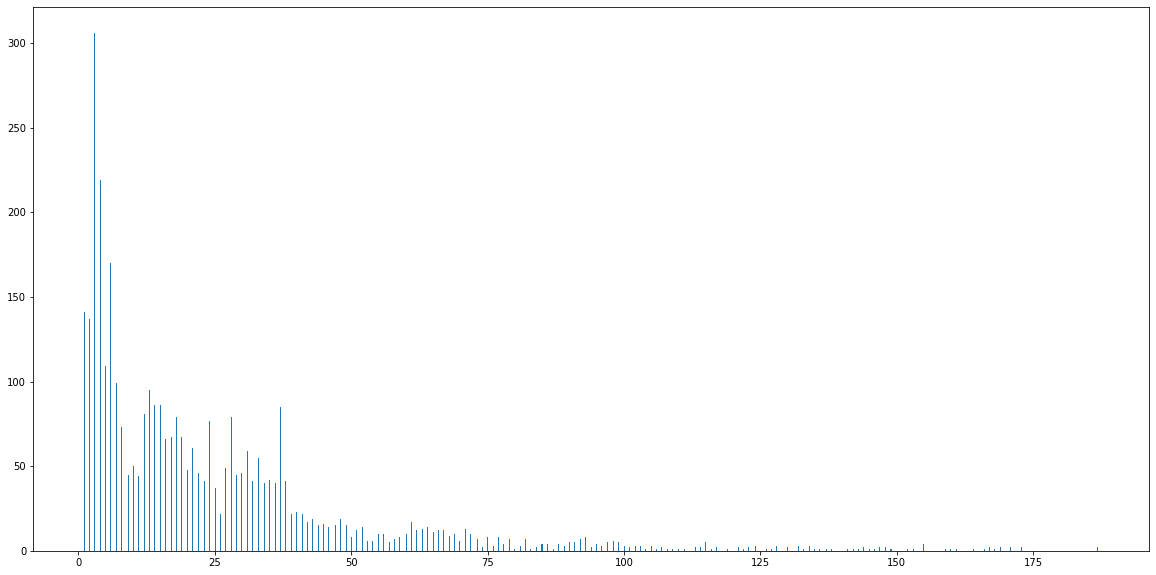

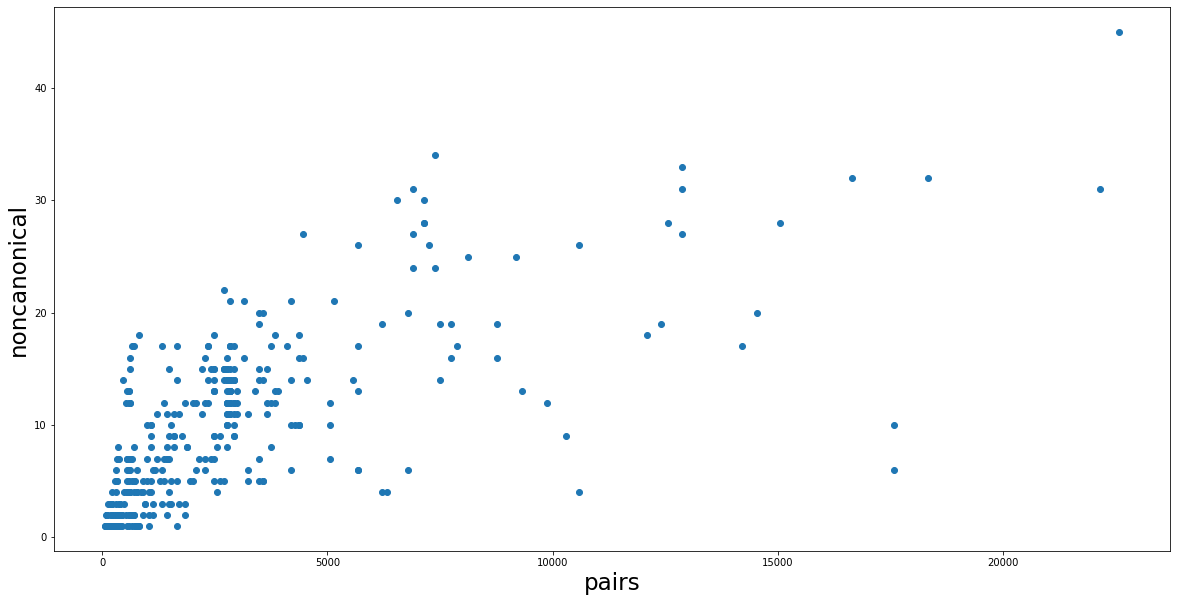

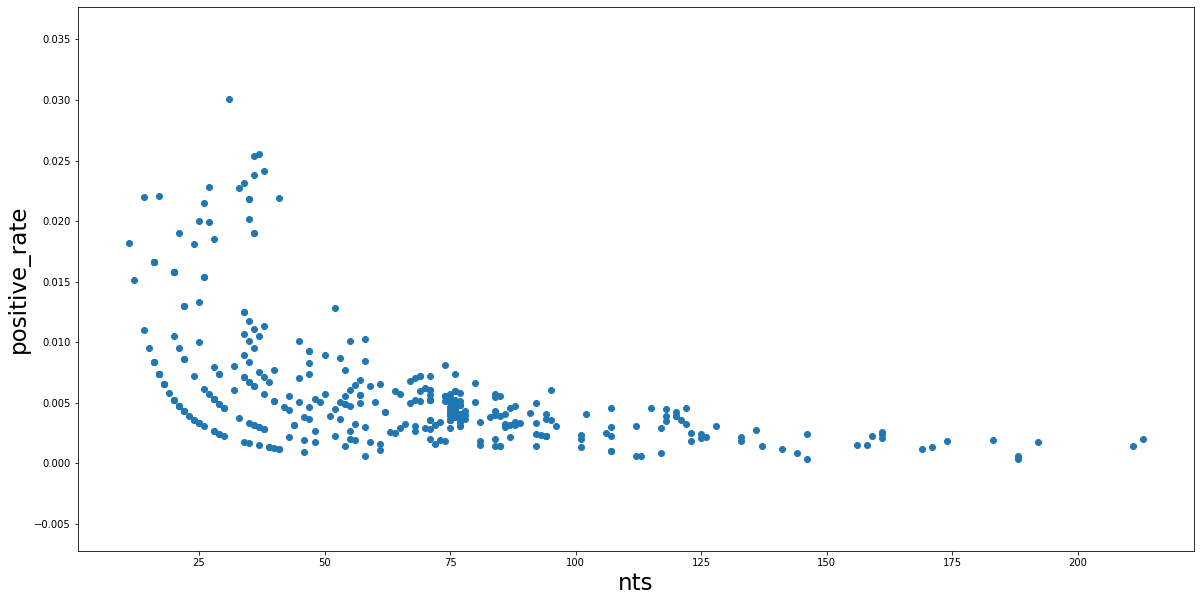

In [15]:
draw_classification_stats(short_chains)

Заметим, что 21 цепочка содержит ~75% неканочнических спариваний. Это согласуется с линейной зависимостью между количеством нуклеотидов и количеством спариваний, которую мы наблюдали выше.

In [16]:
long_chains = [c for c in chains_for_classification if c['nts'] >= 300]
len(long_chains)

21

noncanonical sum: 9306; nts sum: 43477; pairs sum: 52476413; mean_positive_rate: 0.0002569834883440053
Noncanonical dists distribution


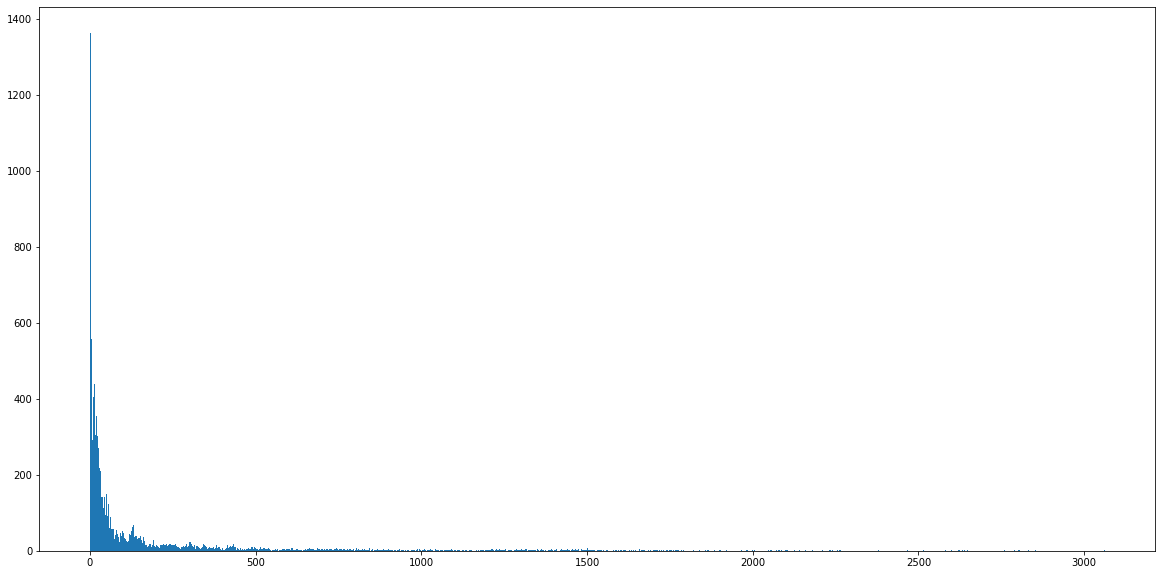

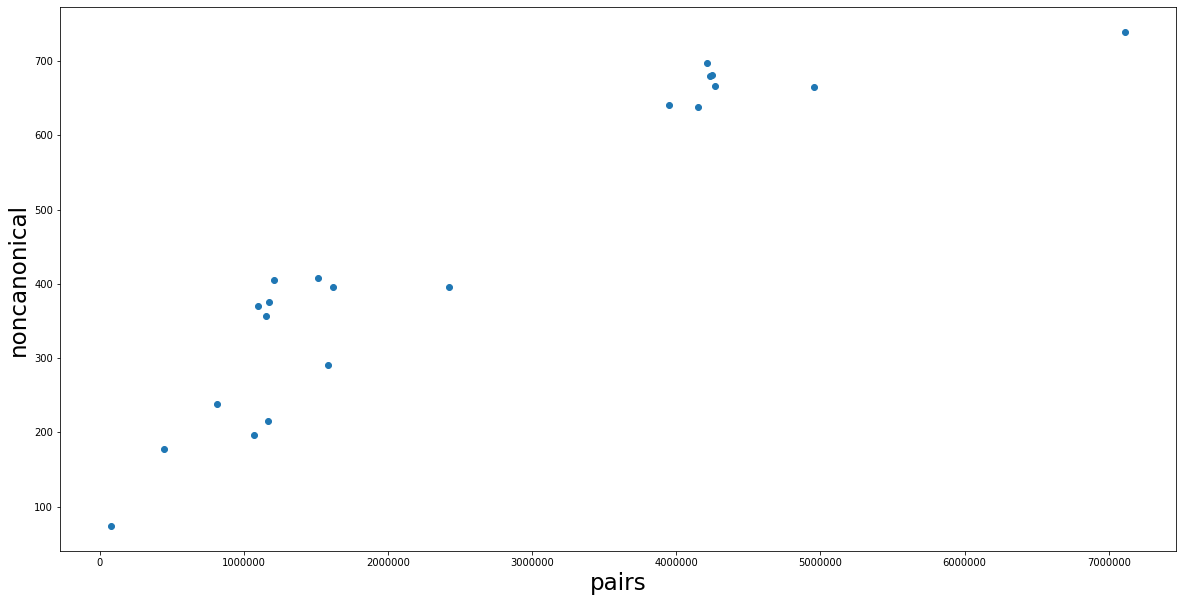

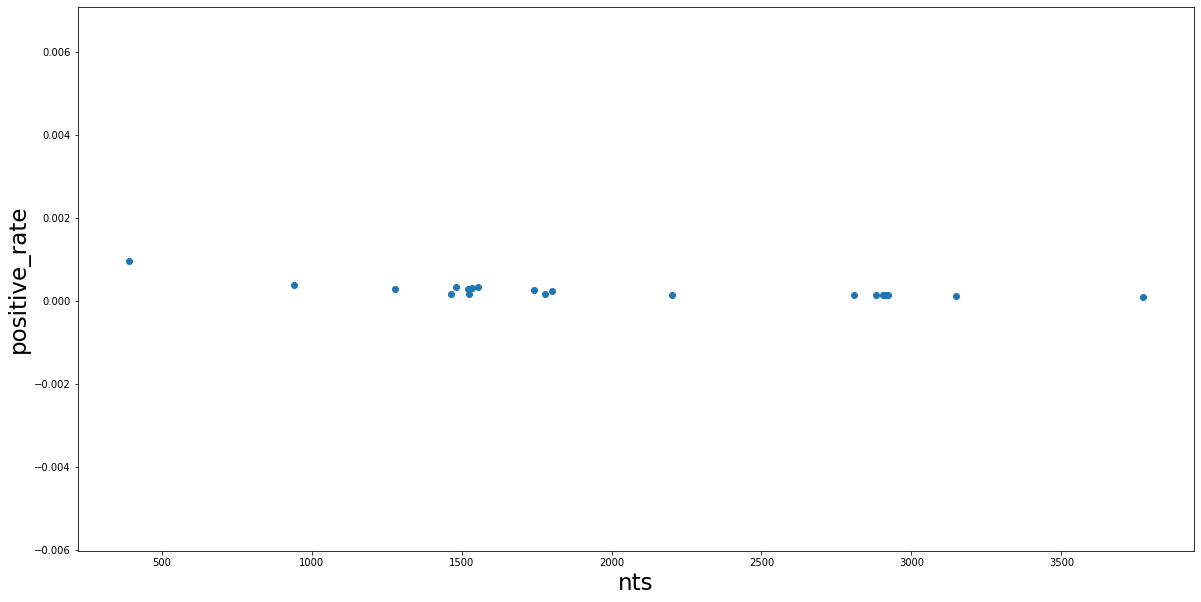

In [17]:
draw_classification_stats(long_chains)

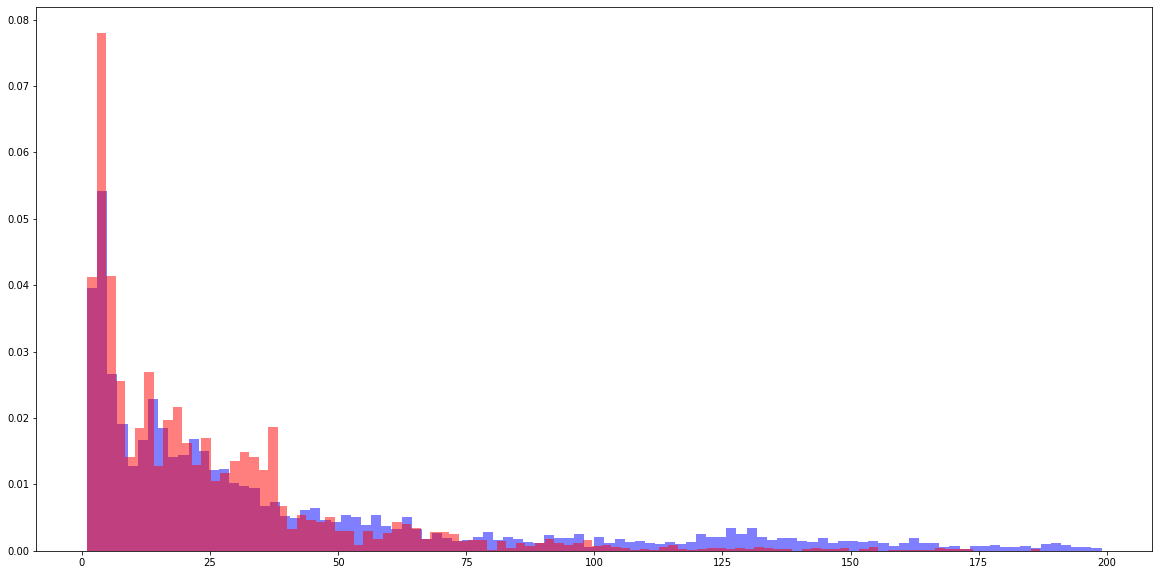

In [19]:
long_noncanonical_dists = np.array([d for d in sum([c['noncanonical_dists'] for c in long_chains], []) if d < 200], 
                                   dtype=np.float)
short_noncanonical_dists = np.array(sum([c['noncanonical_dists'] for c in short_chains], []), 
                                    dtype=np.float)

plt.figure(figsize=(20, 10))
plt.hist(long_noncanonical_dists, bins=100, alpha=0.5, color='b', density=True);
plt.hist(short_noncanonical_dists, bins=100, alpha=0.5, color='r', density=True);

Для длинных цепочек распределение расстояний очень похоже на распределение расстояний для коротких.

Огромный дисбаланс классов и форма распределения расстояний наводят на следующую идею: генерировать негативные пары для будущего обучения не случайно, а локально. Меру локальности предлагается определить следующим образом: построим график $A$ зависимости количества неканонических пар, расстояние между нуклеотидами в которых не превосходит $l$ от $l$. Построим также график $B$ зависимости количества всевозможных пар нуклеотидов в выборке, расстояние между нуклеотидами в которых не превосходит $l$ от $l$. Таким образом, ввиду локальности спариваний график $A$ должен выйти на плато очень быстро, пока график $B$ ещё не успел сильно вырасти.

In [34]:
def get_subchain_stats(chains):
    list_size = max([c['nts'] for c in chains]) + 1
    
    num_pairs = [0] * list_size
    num_noncanonical = [0] * list_size
    
    for chain in chains:
        nts = chain['nts']
        noncanonical_dists = chain['noncanonical_dists']
        
        for subchain_len in range(2, nts + 1):
            num_pairs[subchain_len] += (2 * nts - subchain_len) * (subchain_len - 1) // 2
            num_noncanonical[subchain_len] += sum(1 for dist in noncanonical_dists if dist <= subchain_len)
        
        for subchain_len in range(nts + 1, list_size):
            num_pairs[subchain_len] += nts * (nts - 1) // 2
            num_noncanonical[subchain_len] += len(noncanonical_dists)
            
    return {
        'pairs': num_pairs,
        'noncanonical': num_noncanonical
    }

In [35]:
def draw_locality_stats(chains, x_vert):
    subchain_stats = get_subchain_stats(chains)
    
    xs = np.arange(len(subchain_stats['pairs']))

    plt.figure(figsize=(20, 10))
    plt.title('all pairs', fontsize=23)
    plt.axvline(x=x_vert, c='r')
    plt.plot(xs, subchain_stats['pairs'])

    plt.figure(figsize=(20, 10))
    plt.title('noncanonical pairs', fontsize=23)
    plt.axvline(x=x_vert, c='r')
    plt.plot(xs, subchain_stats['noncanonical'])

    plt.figure(figsize=(20, 10))
    plt.title('noncanonical / all', fontsize=23)
    plt.axvline(x=x_vert, c='r')
    plt.plot(xs, [n / p if p != 0 else 0 for n, p in zip(subchain_stats['noncanonical'], subchain_stats['pairs'])])

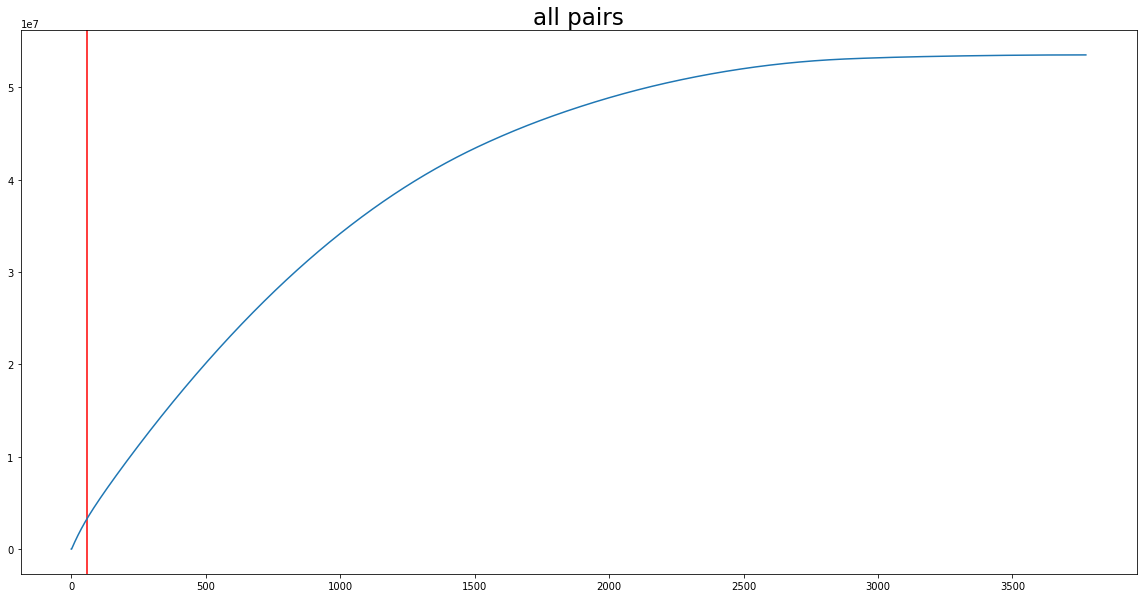

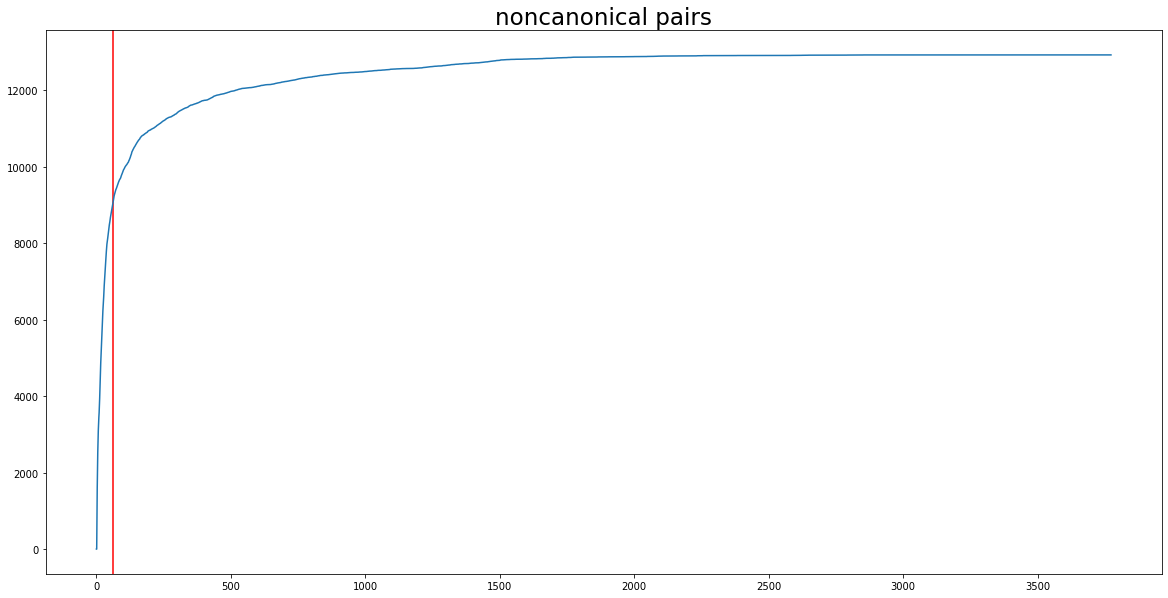

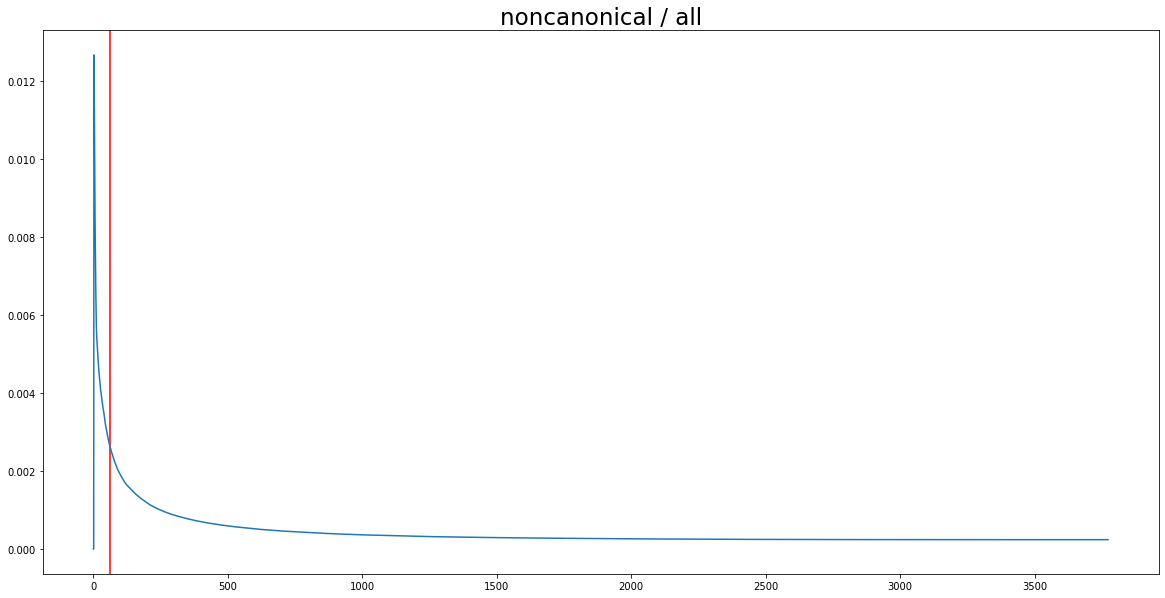

In [36]:
draw_locality_stats(chains_for_classification, 60)

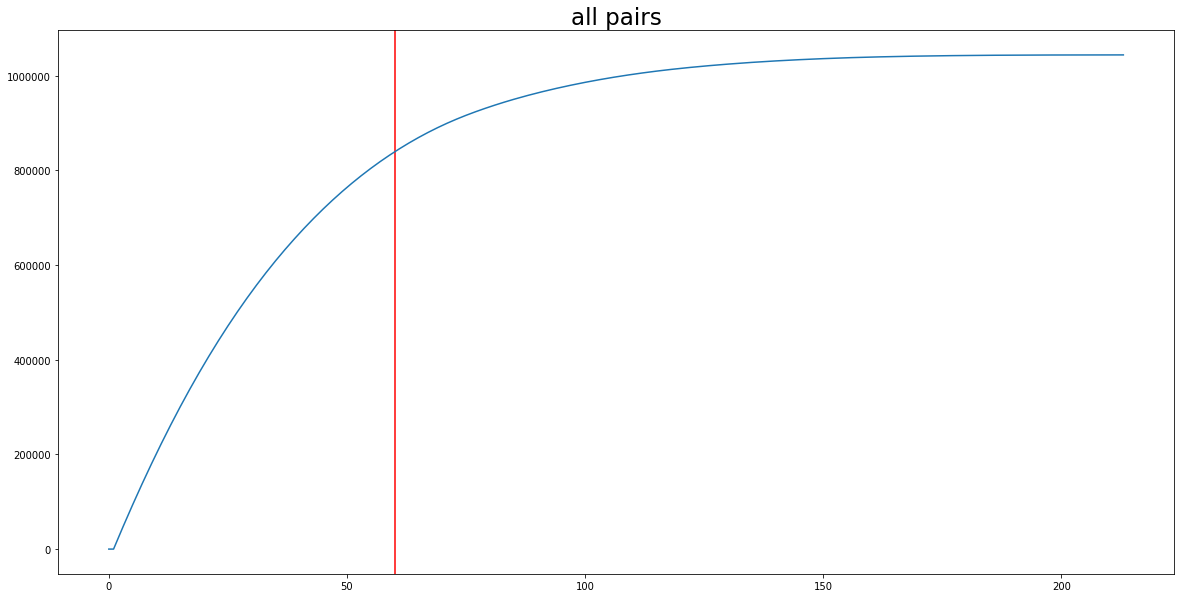

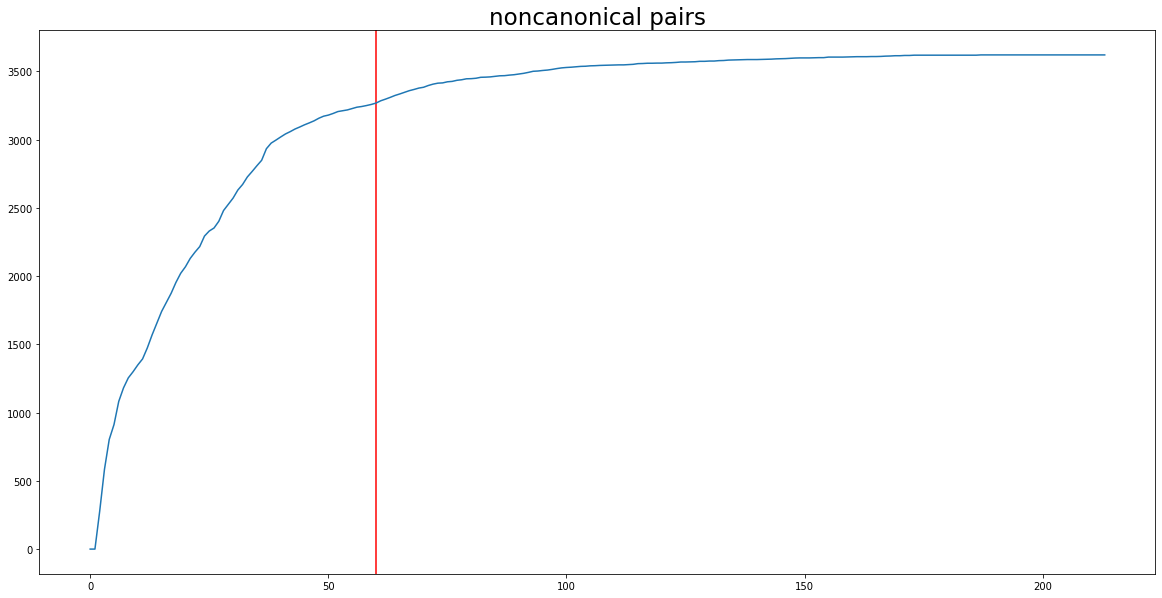

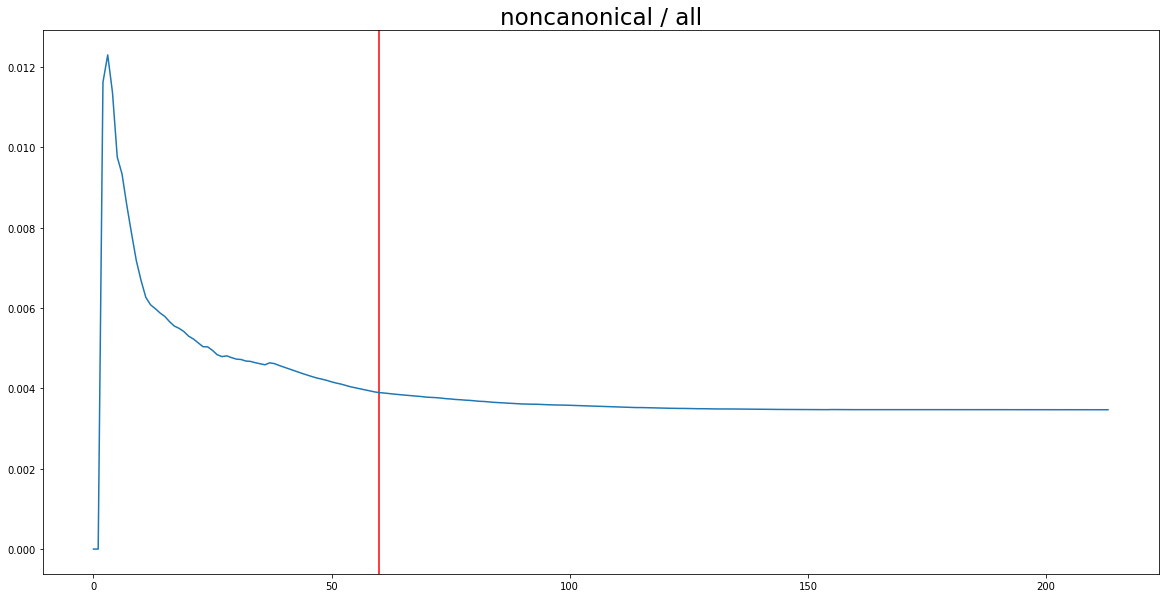

In [37]:
draw_locality_stats(short_chains, 60)

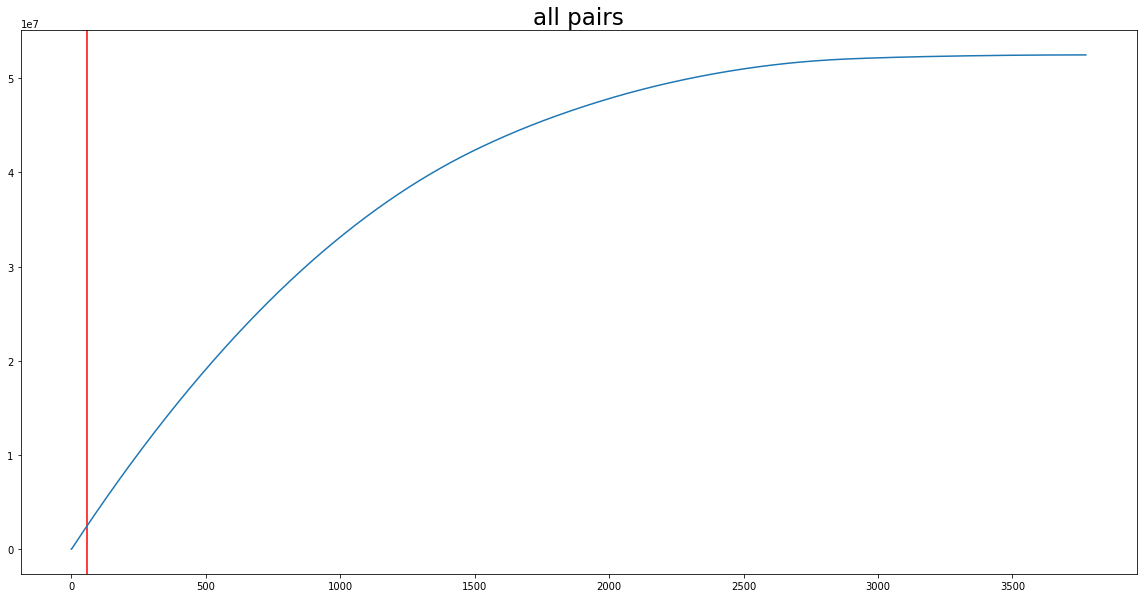

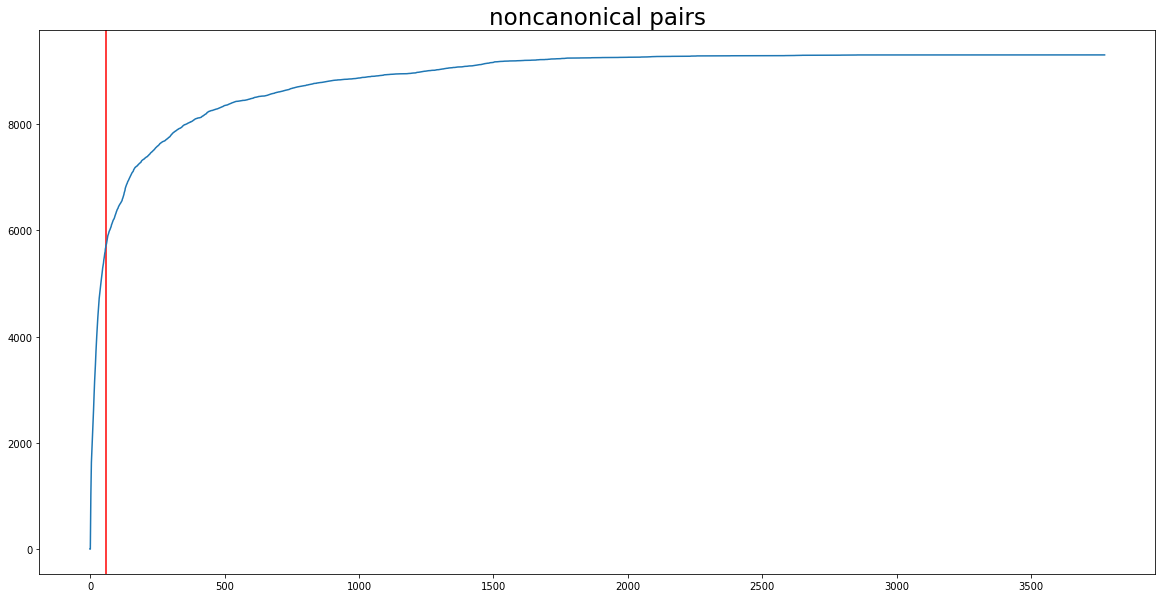

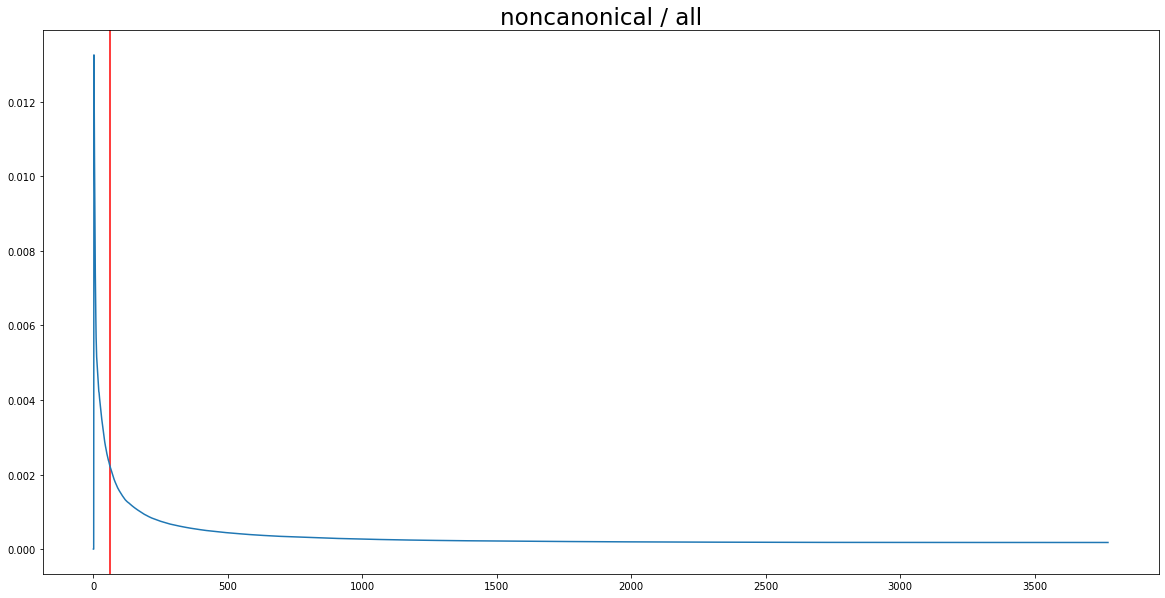

In [38]:
draw_locality_stats(long_chains, 60)

В итоге получаем, что можно отбросить много негативных пар, при этом почти не отбрасывая позитивные, поставив threshold на расстояние в паре. Это наблюдение позволит сэкономить время на вычислениях экспериментов. Пары на больших расстояниях предлагается в первом приближении вообще не рассматривать

Сохраним цепочки, с которыми будем работать.

In [39]:
chains_for_classification_ids = [c['id'] for c in chains_for_classification]

with open('/home/mikhail/bioinformatics/data/chains_for_classification.json', 'w') as outfile:
    json.dump(chains_for_classification_ids, outfile)

В URS-заметке я также видел предложение выкидывать нуклеотиды в начале и в конце цепочек. Мне непонятно, зачем это делать. Оценим, сколько positive-семплов нам это будет стоить, если нисколько -- ок, можно выкинуть, если хотя бы 5% -- то оставим.

In [40]:
threshold_counter = Counter()

for chain in all_chains:
    for bp in chain.noncanonical_bps:
        dist = min([abs(nt.index - border) 
                    for nt in [bp.nt_left, bp.nt_right] 
                    for border in [1, len(chain.nts)]])
        threshold_counter[dist] += 1

dists = np.arange(0, max(threshold_counter) + 1)
threshold_nums = np.cumsum([threshold_counter.get(dist, 0) for dist in dists])

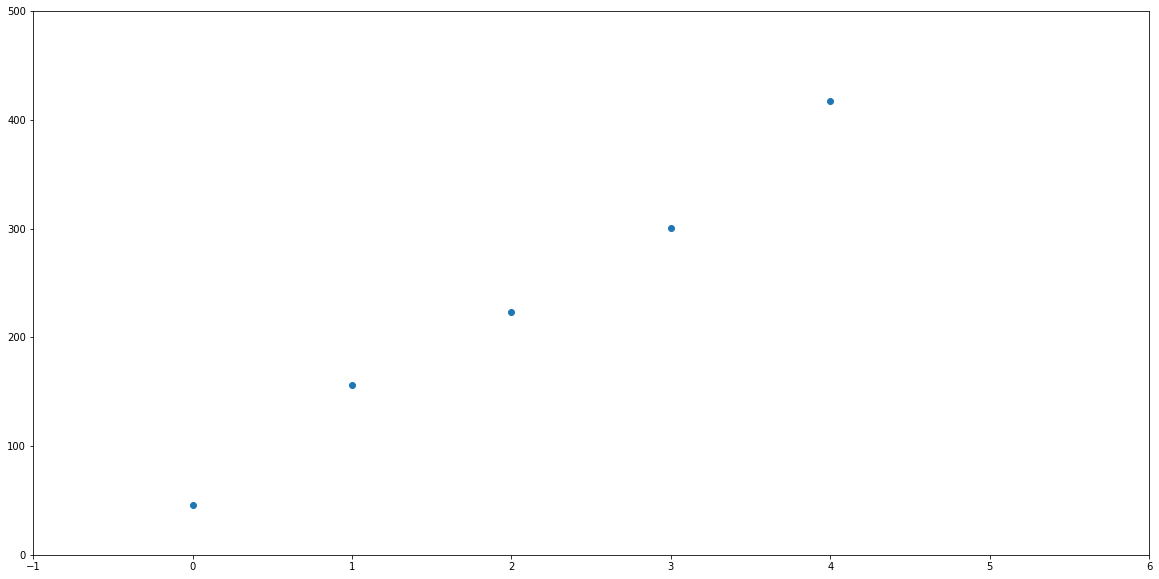

In [41]:
plt.figure(figsize=(20, 10))

plt.xlim(-1, 6)
plt.ylim(0, 500)
plt.scatter(dists, threshold_nums)

Неканонические спаривания на концах -- значимое явление, поэтому игнорировать мы их не будем.